In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Кластеризация

Наша задача - предсказать есть диабет у индивида или нет. В качестве таргета - колонка Diabetes. В нем три различных значения: `0`, `1`, `2`. `0` означает, что наблюдаемой здоров, `1` значит, что есть риск диабета, `2` означает наличие диабета. В качестве признаков будем использовать пол, количество лет в США, доход семьи и некоторые показатели, измеренные медицинскими работниками.  

**Задание 1.** В этой части ДЗ попробуем использовать кластеризацию как инструмент при проведении моделирования в задаче классификации

In [2]:
df = pd.read_csv('datahw21.csv', index_col='Unnamed: 0')

df.head()

,Gender,Years_in_US,Family_income,ArmCircum,SaggitalAbdominal,GripStrength,Breast_fed,Diabetes
0,1,0.0,0.84,35.3,20.6,55.2,2.0,2.0
1,1,0.0,1.78,34.7,24.4,61.5,2.0,2.0
2,1,0.0,4.51,33.5,25.6,91.0,2.0,2.0
3,1,0.0,2.52,21.0,14.9,32.2,2.0,0.0
4,2,0.0,5.00,25.2,20.7,30.9,2.0,0.0


<Axes: >

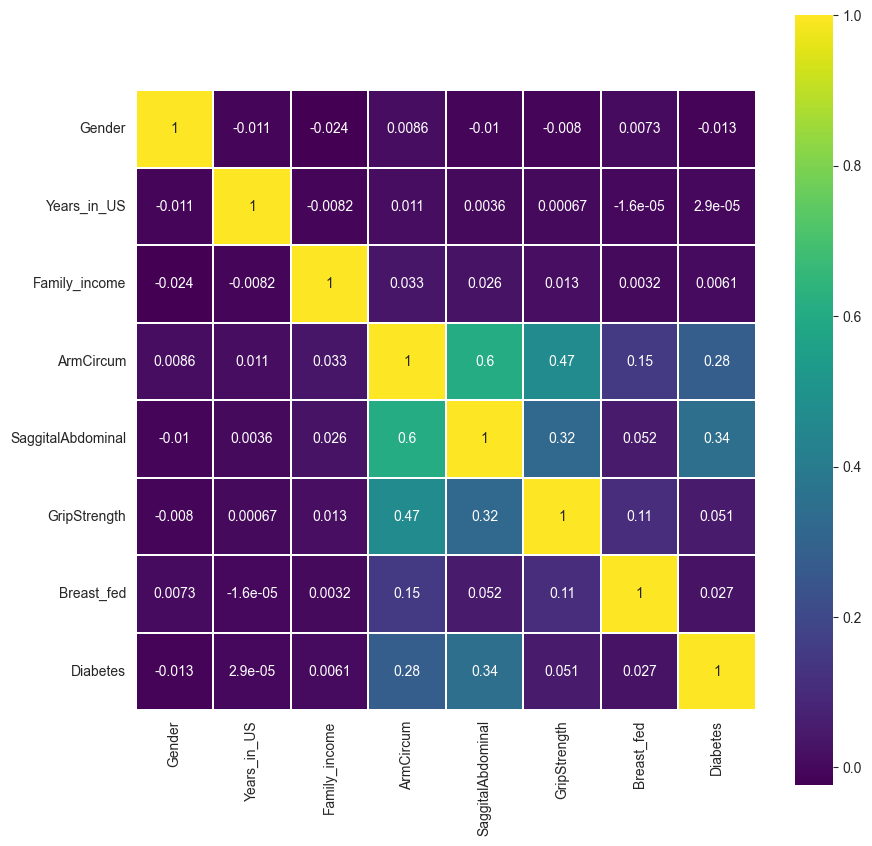

In [5]:
### Посмотрим как устроены данные
### Изобразим корреляционную матрицу

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

In [6]:
### Разделим выборку на трейн-тест

data = df.drop(["Diabetes"], axis=1)
target = df[["Diabetes"]]

X_train, X_test, Y_train, Y_test = train_test_split(data,
                                                    target, 
                                                    test_size=0.25,
                                                    random_state=1)

Для того, чтобы использовать K-means, лучше будет отнормировать данные.

In [12]:
### Воспользуемся StandardScaler

### Your code is here

scl = StandardScaler()
X_train_sc = scl.fit_transform(X_train)
X_test_sc = scl.transform(X_test)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

Обучим K-Means с параметрами `n_clusters` = 3, `tol` = 0.0005. Выбор параметров обусловлен тем, что у нас три возможных значения таргета. Но в целом основной подход подбора количества кластеров - по кривой зависимости внутрикластерного и межкластерного расстояний от количества кластеров.

Установите `random_state` = 1

In [16]:
### Your code is here
km = KMeans(n_clusters=3, tol=0.0005, random_state=1)
km.fit(X_test_sc)

KMeans(n_clusters=3, random_state=1, tol=0.0005)

pПосчитаем качество на изначальных данных(нормированных). Для этого обучите с дефолтными параметрами `RandomForestClassifier`, `LogisticRegression`, `LinearSVC`. Там, где нужно, установите `random_state` = 1. (1б)

In [18]:
### Your code is here

rf = RandomForestClassifier()
lr = LogisticRegression()
svm = LinearSVC()

rf.fit(X_train_sc, Y_train)
lr.fit(X_train_sc, Y_train)
svm.fit(X_train_sc, Y_train)


print(f"RF acc: {round(accuracy_score(Y_test, rf.predict(X_test_sc)), 3)}")
print(f"LR acc: {round(accuracy_score(Y_test, lr.predict(X_test_sc)), 3)}")
print(f"SVM acc: {round(accuracy_score(Y_test, svm.predict(X_test_sc)), 3)}")

RF acc: 0.889
LR acc: 0.888
SVM acc: 0.892


Добавьте в признаковое описание номер кластера и посчитайте качество с новым признаком! Стало ли качество хоть сколько-то лучше? (1б)

In [33]:
### Your code is here
X_train_k = X_train_sc.copy()
X_train_k["Cluster_num"] = pd.DataFrame(km.predict(X_train_sc))

X_test_k = X_test_sc.copy()
X_test_k["Cluster_num"] = pd.DataFrame(km.predict(X_test_sc))

rf = RandomForestClassifier(random_state=1)
lr = LogisticRegression()
svm = LinearSVC()

rf.fit(X_train_k, Y_train)
lr.fit(X_train_k, Y_train)
svm.fit(X_train_k, Y_train)


print(f"RF acc: {round(accuracy_score(Y_test, rf.predict(X_test_k)), 3)}")
print(f"LR acc: {round(accuracy_score(Y_test, lr.predict(X_test_k)), 3)}")
print(f"SVM acc: {round(accuracy_score(Y_test, svm.predict(X_test_k)), 3)}")


RF acc: 0.887
LR acc: 0.89
SVM acc: 0.892


Посчитаем расстояния от объектов до центров кластеров. Для этого воспользуемся методом `transform` обученного класса kmeans.

Обучим и посчитаем метрики исключительно на расстояниях до центра. Убедимся, что такой подход имеет право на существование, если данные позволяют, то качество не сильно должно пострадать. А в каких-то случаях может оказаться даже лучше! Таким образом можно снижать размерность данных. (2б)

In [34]:
### Your code is here
length1 = km.transform(X_train_sc)
length2 = km.transform(X_test_sc)

rf = RandomForestClassifier(random_state=1)
lr = LogisticRegression()
svm = LinearSVC()

rf.fit(length1, Y_train)
lr.fit(length1, Y_train)
svm.fit(length1, Y_train)

print(f"RF acc: {round(accuracy_score(Y_test, rf.predict(length2)), 3)}")
print(f"LR acc: {round(accuracy_score(Y_test, lr.predict(length2)), 3)}")
print(f"SVM acc: {round(accuracy_score(Y_test, svm.predict(length2)), 3)}")



RF acc: 0.881
LR acc: 0.892
SVM acc: 0.892
